In [2]:
import os
if __name__ == '__main__':
    
    execfile(os.environ['PYTHONSTARTUP'])
    execfile(STARTUP_IG2018)

    %matplotlib inline

    import sys, imp
    #import pickle
    from lmfit import minimize, Parameters
    import copy
        
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def normalize_time(time):
    """
    returns a time vector from 0 to 1 of the length of time
        and the time step dt in dimentional units
    """
    time=np.copy(time)
    dt=np.diff(time).mean()#G.dt_periodogram
    time=(time-time[0])/dt#np.arange(0,time.size, 1)
    return (time)/(time[-1]) , dt


In [4]:
def gaussian(x,x0,sigma):
  return np.exp(-np.power((x - x0)/sigma, 2.)/2.)


/home/lbaratgin/env_python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


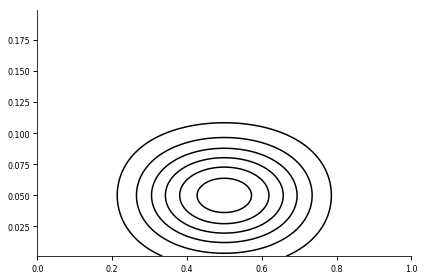

In [5]:
#%% generate some data_ano
if __name__ == '__main__':

    f=np.arange(1/1000.0, .2, 0.001)
    time=np.arange(0, 1, 0.001)

    tt, ff = np.meshgrid(time, f)
    fake_data=  np.sin(tt*np.pi)**4 * gaussian( ff, .05, 0.03)

    plt.contour(tt, ff, fake_data, colors='k')

In [6]:
# %% basic functions
def gamma_time_normlized_amp(time, gammapar=2, loc=.2, scale=0.1):
    from scipy.stats import gamma
    """
    configured for normalized time scale (0, 1)
    gammapar > 1
    time > 0
    loc is position 0 ..1
    scale  >0 .. \approx 0.3
    """
    gamma_mod=gamma(gammapar, loc = loc, scale = scale).pdf(time)
    return  gamma_mod/gamma_mod.max()

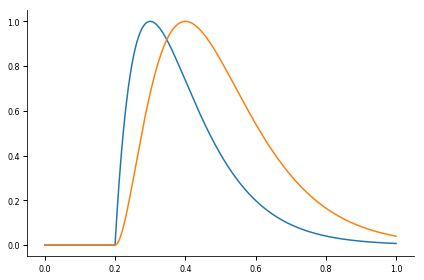

In [7]:
if __name__ == '__main__':
    plt.plot(time, gamma_time_normlized_amp(time))
    plt.plot(time, gamma_time_normlized_amp(time, gammapar=3, loc=.2, scale=0.1) )


In [8]:
# %% JONSWAP

def JONSWAP_bulk(f, floc=0.04, famp=1e-2,  gamma=3.3, peak_std=1e-1):
    """
    see Ocean Surface waves - S. R. Massel eq.3.69 and eq.3.81

    """
    B=0.74 #
    g=9.81
    w=f*2*np.pi
    wp=floc*2*np.pi
    stretch=5/4

    #peak_std=1e-01 #0.00555
    #scale_std=1e-2
    alpha=famp
    #stretch=5/4

    delta=np.exp(-(w-wp)**2 / ( 2*peak_std**2 *wp**2 ) )
    peak_factor=gamma**delta
    return alpha * w**(-5) * np.exp(-stretch*  (w/wp)**-4)*peak_factor # units of m^2 / Hz
    #np.exp(-B *(g/(w*U))**4)

In [9]:
def pierson_moskowitz_default(f, U):
    """
    see Ocean Surface waves - S. R. Massel eq.3.79 and eq.3.80

    """

    g=9.81
    wp=0.879*g / U
    w=2.*np.pi*f
    sigma=0.04 *g / wp**2.0
    alpha=5.0* (wp**2.0 *sigma / g)**2.0

    return  alpha * w**(-5.0) * g**2.0 *np.exp(-5./4.0 * (w/wp)**-4)#

In [10]:
def pierson_moskowitz_fetch_limit(f, X,  U):
    """
    see Ocean Surface waves - S. R. Massel eq.3.81 - eq.3.84

    """
    g=9.81 # m s*-2
    w=2.*np.pi*f # rad/sec

    alpha=0.076*(g *X /U**2)**(-0.22) #non-dimentional
    wp= 7.* np.pi * (g /U) * (g * X /U**2)**(-0.33)
    print('wp='+str(wp))

    sigma_p=0.07
    sigma_pp=0.09
    sigma= np.array([[sigma_p if i else sigma_pp][0]  for i in list(w<=wp)  ])

    gamma=3.3
    delta=np.exp(-(w-wp)**2 / ( 2.*sigma**2. *wp**2. ) )
    peak_factor=gamma**delta

    return alpha * g**2.0 * w**(-5.) * np.exp(-5./4.0 *  (w/wp)**-4)# Hz**-5 m**2 /s**4  = m**2 sec

In [11]:
def JONSWAP_default(f, X, U=15, gamma=3.3):
    """
    see Ocean Surface waves - S. R. Massel eq.3.81 - eq.3.84
    inputs:
    X         fetch lenght in meters about 5e5,
    U          wind speed in m/s about 15 m/s
    gamma is defined in the JONSWAP spectrum as 3.3. However, The JONSWAP spectrum is a psectrum for a fully deleoped sea, and likely not observed in a remote location.
    varying gamma to less then its JONSWAP value will mimic the attenuation of the peak with travel time to the limit of gamma=1, which is the PM spectrums
    """
    g=9.81 # m s*-2
    w=2.*np.pi*f # rad/sec

    alpha=0.076*(g *X /U**2)**(-0.22) #non-dimentional
    wp= 7.* np.pi * (g /U) * (g * X /U**2)**(-0.33)
    #print('wp='+str(wp))
    #print('nu='+str(wp*U/(g)))

    sigma_p=0.07
    sigma_pp=0.09
    sigma= np.array([[sigma_p if i else sigma_pp][0]  for i in list(w<=wp)  ])

    gamma=3.3
    delta=np.exp(-(w-wp)**2 / ( 2.*sigma**2. *wp**2. ) )
    peak_factor=gamma**delta

    return alpha * g**2.0 * w**(-5.) * np.exp(-5./4.0 *  (w/wp)**-4)*peak_factor # Hz**-5 m**2 /s**4  = m**2 sec  ?


In [12]:
g=9.81

def X_tilde(X, U10):
    return g*X/U10**2

def alpha(f_max, U10):
    return 0.033*(f_max*U10/g)**0.67

def f_max(U10, X):
    return 3.5*g/U10*X_tilde(X,U10)**(-0.33)

wp=0.532273712527


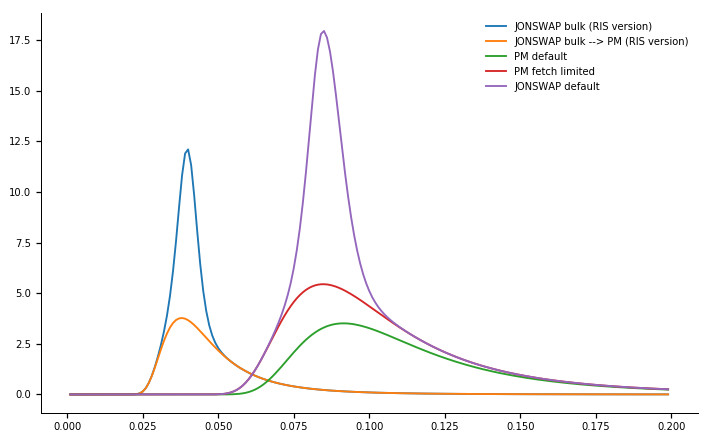

In [13]:
if __name__ == '__main__':

    M.figure_axis_xy()
    plt.plot(f, JONSWAP_bulk(f, gamma=3.3), label='JONSWAP bulk (RIS version)')
    plt.plot(f, JONSWAP_bulk(f, gamma=1), label='JONSWAP bulk --> PM (RIS version)')

    plt.plot(f, pierson_moskowitz_default(f, 15),  label='PM default')
    plt.plot(f, pierson_moskowitz_fetch_limit(f, 5e5,  15), label='PM fetch limited')
    plt.plot(f, JONSWAP_default(f, 5e5,  15), label='JONSWAP default')
    plt.legend()

In [14]:
def gamma_time_JONSWAP_default(time, f,
                   slope_t, intersectT,
                   tgammapar, tscale,
                    f_max,
                    U10= 20,
                    gamma_peak=3.3,
                    amplitude=1,
                    plot=False):

    """
    This method calculated a 2D shaped function given the parameters:
    inputs:

    time        normalized time [0, 1] np.array
    f           frequency in the swell band, np.array,

    slope_t     slope of the "dispersed peak frequencies" df/dt [Hz/ normalized time]
    intersectT  intersect of that line in units of normalized time

    tgammapar   gamma parameter of the gamma function in time
    tscale      scaling parameter of the gamma function

    f_max       =0.04, location of the peak frequency on the JONSWAP spectrum
    U10           Wind speed that generates the waves
    gamma_peak  =3.3,  gamma peak parameter of the JONSWAP spectrum

    amplitude   amplitude of the whole function.  if =1 , peak amplitude corresponds to JONSWAPs values

    plot        True, False. Simple plot of the output function

    return:
                2d function with the shape of [time,freq]
    """

    #intersectf=intersect-intersect/slopet
    intersectF=-intersectT*slope_t
    pfreq=time*slope_t+intersectF
    #print('intersect F=' + str(intersectF))

    #intersectf=intersect#-intersect/slope
    slopeF=1/slope_t
    pfreq_forgamma=f*slopeF+intersectT

    #rint(pfreq.shape)
    tt, line=np.meshgrid(time, pfreq_forgamma)
    #print(line)
    #print(tt)
    func_t= gamma_time_normlized_amp(tt, gammapar=tgammapar, loc=line, scale=tscale)
    #func_t_temp= (tamp*np.exp(- (time-t_center )**4 / tsigma ))
    #print(func_t.shape)

    """ Define X(f_max and U) here """
    def X(f_max, U10):
        return 3.5**3*g**2/U10/f_max**3
    

    func_freq_temp= JONSWAP_default(f, X=X(f_max,U10),  U=U10, gamma=gamma_peak)

    #func_freq_temp=   (famp*np.exp(- (f-fcenter)**2 / fsigma ))
    tt, func_freq= np.meshgrid( time, func_freq_temp)

    if plot:
        F=M.figure_axis_xy(8,10)
        plt.subplot(3, 1, 1)
        plt.contourf(tt, ff, func_t)
        plt.plot(time, pfreq)
        plt.ylim(f.min(), f.max())


        plt.subplot(3, 1, 2)
        #plt.plot(f, func_freq.mean(1))
        plt.contourf(tt, ff,func_freq)

        plt.subplot(3, 1, 3)
        plt.contourf(tt, ff, func_t * func_freq)
        #plt.ylim(0.04,0.08)
        plt.grid()

    return (func_t * func_freq).T




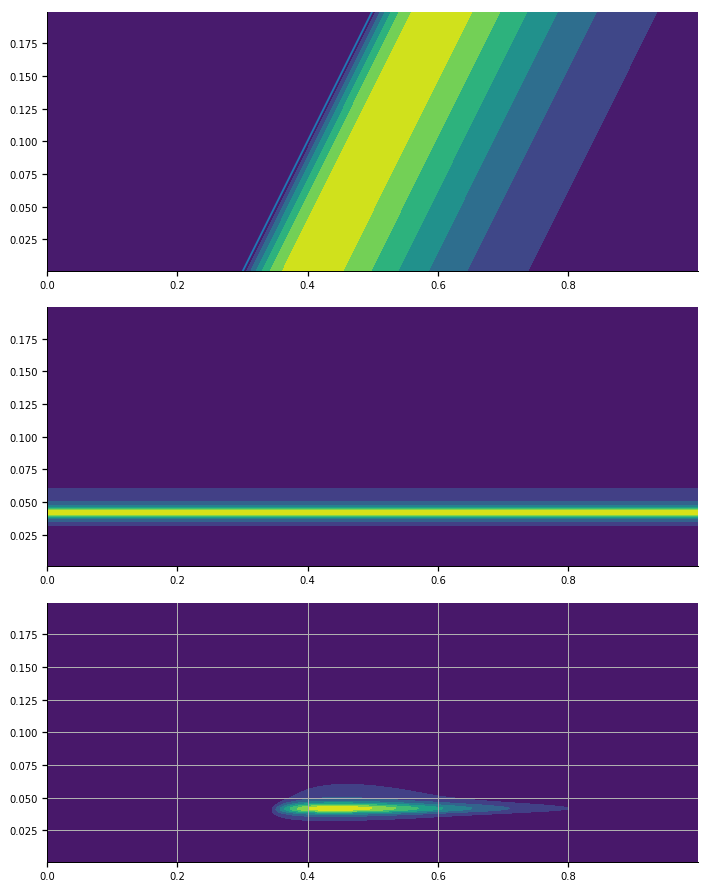

In [15]:
if __name__ == '__main__':
    slope0= 1
    intersect0=.3
    tgammapar0=2
    tscale0=.1

    model_func =gamma_time_JONSWAP_default(time, f, slope0, intersect0, tgammapar0, tscale0, plot=True)

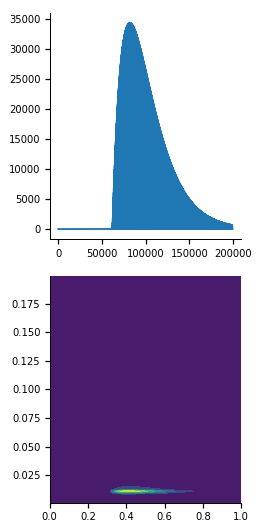

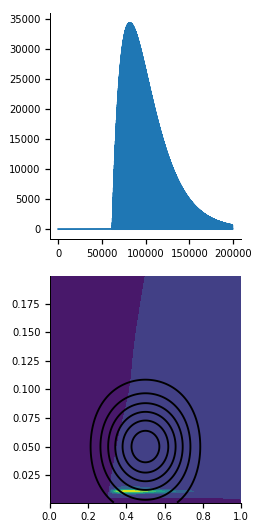

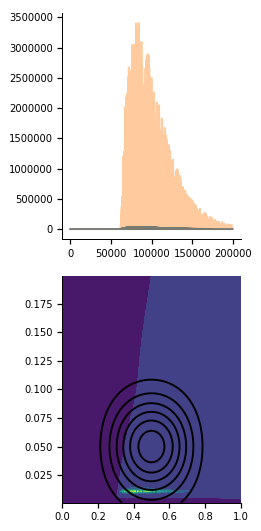

In [16]:
def residual_JONSWAP_default_gamma(value_dict, time, f, data=None, weight=None, eps=None):
    """
    derived the residual between model and data given params_local.

    inputs:
    value_dict         dictionary with parameters, or lmfit.parameters instance.
                       contains all parameters that are needed for creating the model.
    time               time axis
    f                  frequency axis
    data               data, same shape as time and f, if None function returns model as a 1d vector.
    weight             weigthing for each of the data points, can be a 1d or 2d Vector, must have the same size as data, if None, no weighting is applied
    eps                is just a dummy
    """
    from lmfit import Parameters
    from collections import OrderedDict

    if type(value_dict) is Parameters:
        vd=value_dict.valuesdict()
    elif (type(value_dict) is dict) | (type(value_dict) is OrderedDict):
        vd=value_dict
    else:
        raise ValueError('value_dict is eiher a dicitionary or a Params instance')

    model= vd['amp'] * gamma_time_JONSWAP_default(time, f,
                        vd['slope'], vd['intersect'],
                        vd['tgammapar'], vd['tscale'],
                        vd['f_max'], vd['power_slope'], vd['power_exp'],
                        plot=False )

    #tt, tt= np.meshgrid(time, ff)
    model1d=model.reshape(model.shape[0]*model.shape[1])


    if data is not None:
        if np.size(data.shape) != 1:
            if model.shape == data.shape:
                data1d=data.reshape(data.shape[0]*data.shape[1])
                nan_track=np.isnan(data1d)
            elif model.shape == data.T.shape:
                data1d=data.T.reshape(data.T.shape[0]*data.T.shape[1])
                nan_track=np.isnan(data1d)
            else:
                raise TypeError("data shape does not match")

    if weight is not None:
        if (len(weight.shape) == 1) & (model1d.size == weight.size):
            weight1d= weight
        elif (len(weight.shape) == 2) & (model1d.size == weight.size):
            weight1d= weight.reshape(weight.shape[0]*weight.shape[1]).T
        else:
            raise ValueError('weight has not the same dimensions as model. \n' + 'data ' +str(model.shape) +  '\n weight '+str(weight.shape) )


    if data is None:
        return model1d
    if (weight is not None):
        #print('use weight')
        d=(model1d - data1d)*weight1d
        d[nan_track]=np.nan
        return d
    if (weight is None) and (data is not None):
        d= model1d - data1d
        d[nan_track]=np.nan
        return d

if __name__ == '__main__':
    #http://cars9.uchicago.edu/software/python/lmfit/fitting.html
    params=Parameters()

    params.add('slope', value= slope0, min=slope0*.1 , max=slope0*10)
    params.add('intersect', value= intersect0, min=-0.5, max=.5)

    #params.add('tamp', value= tamp0, min=0., max=1)
    params.add('tgammapar', value= tgammapar0, min=0.0001, max=4)
    params.add('tscale', value= tscale0, min=0, max=.1)

    params.add('f_max', value= 0.01, min=0., max=.1)
    params.add('power_slope', value= 2, min=0.1, max=25)
    params.add('power_exp', value= 2, min=0.1, max=4)

    params.add('amp', value= 1, min=1e-4, max=1e2)

if __name__ == '__main__':

    # %% should return model:
    model1d = residual_JONSWAP_default_gamma(params, time, f)
    M.figure_axis_xy(3, 6)

    plt.subplot(2, 1, 1)
    plt.plot(model1d)

    plt.subplot(2, 1, 2)
    plt.contourf(time, f, model1d.reshape(time.size, f.size).T)

    # %% should return the residual
    resid1d = residual_JONSWAP_default_gamma(params, time, f, data=fake_data)

    M.figure_axis_xy(3, 6)

    plt.subplot(2, 1, 1)
    plt.plot(resid1d)

    plt.subplot(2, 1, 2)
    plt.contour(time, f, fake_data, colors='k')
    plt.contourf(time, f, resid1d.reshape(time.size, f.size).T)

    # %% should return the residual weighted residual
    weightdummy=(fake_data*0+2)
    len(weightdummy.shape)
    weightdummy.size
    len(fake_data.shape)
    fake_data.size
    weightdummy.shape

    # %%
    weightdummy =100.0 * np.random.random(fake_data.shape)#.reshape(fake_data.shape[0]*fake_data.shape[1] )
    resid1d_weight = residual_JONSWAP_default_gamma(params, time, f, data=fake_data, weight=weightdummy )

    M.figure_axis_xy(3, 6)

    plt.subplot(2, 1, 1)
    plt.plot(resid1d)
    plt.plot(resid1d_weight, alpha=0.4)

    plt.subplot(2, 1, 2)
    plt.contour(time, f, fake_data, colors='k')
    plt.contourf(time, f, resid1d_weight.reshape(time.size, f.size).T)




In [17]:
# %%
def Jm_regulizer(value_dict, prior):
    """
    returns a Model cost function as list. each item is the cost for each prior given the parameter value in value_dict

    value_dict  is a dict with all values that need to be regulized, can be standard dict or Parameter instance
    prior       is a dict with all priors for this dict

    """

    from lmfit import Parameters
    from collections import OrderedDict


    if type(value_dict) is Parameters:
        vd=value_dict.valuesdict()
    elif (type(value_dict) is dict) | (type(value_dict) is OrderedDict):
        vd=value_dict
    else:
        raise ValueError('value_dict is eiher a dicitionary or a Params instance')

    Jm=list()
    for k,I in prior.iteritems():
        if type(I['m_err']) is float:
            Jm.append(    (I['m0']- vd[k] ) / I['m_err']    )
        else:
            if value_dict[k] >= I['m0']:
                Jm.append( (I['m0']- vd[k] ) / I['m_err'][1] )
            else:
                Jm.append( (I['m0']- vd[k] ) / I['m_err'][0] )
    return Jm


if __name__ == '__main__':
    #test Jm_regulizer with priors
    # create face priors
    prior_errors={'slope': 1.0, 'intersect':.2,
            'tgammapar':.4, 'tscale':0.2,
            'f_max':0.01 ,
             'power_slope':2.0 , 'power_exp':2.0 ,
             'amp': 10.0
             }

    priors=dict()
    for k,I in prior_errors.iteritems():
        priors[k]={'m_err':I, 'm0':params[k].value}

    # fake parameters
    vd=copy.copy(params.valuesdict())
    for k,I in vd.iteritems():
        vd[k]= I *np.random.rand()

    Jm =Jm_regulizer(vd , priors)
    print(Jm)


[0.17544308897561867, 0.8138736382862166, 0.017889610743081624, 0.024660213772460526, 0.0021179598034476556, 2.3182109246282314, 0.1584264492767966, 0.7509282001438233]


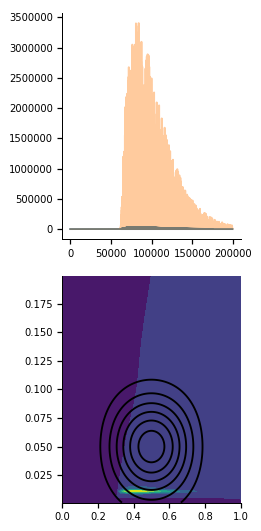

In [18]:
# %%
def cost(value_dict, time, f, data=None, weight=None, prior=None, eps=None):
    """
    Wrapper around residual and regulizer.

    returns 1d cost vector

    eps is just a dummy
    """
    from lmfit import Parameters

    Jd = residual_JONSWAP_default_gamma(value_dict, time, f, data=data, weight=weight)

    if prior is not None:

        # if type(value_dict) is Parameters:
        #     vd=value_dict.valuesdict()
        # elif type(value_dict) is dict:
        #     vd=value_dict
        # else:
        #     raise ValueError('value_dict is eiher a dicitionary or a Params instance')

        Jm = Jm_regulizer( value_dict, prior)
        return np.concatenate(( Jd, Jm ))
    else:
        return Jd


# %% test cost
if __name__ == '__main__':

    cost1d_weight = cost(params, time, f, data=fake_data, weight=None, prior=None )

    M.figure_axis_xy(3, 6)

    plt.subplot(2, 1, 1)
    plt.plot(resid1d)
    plt.plot(resid1d_weight, alpha=0.4)

    plt.subplot(2, 1, 2)
    plt.contour(time, f, fake_data, colors='k')
    plt.contourf(time, f, cost1d_weight.reshape(time.size, f.size).T)

    # %%
    cost1d_weight = cost(vd, time, f, data=fake_data, weight=None, prior= priors)